In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.6.2 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.6


In [3]:
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20,10)

In [4]:
adata= sc.read_h5ad("/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_MetaAdded_noNorm.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 1825288 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.'
    var: 'gene_ids', 'feature_types'

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

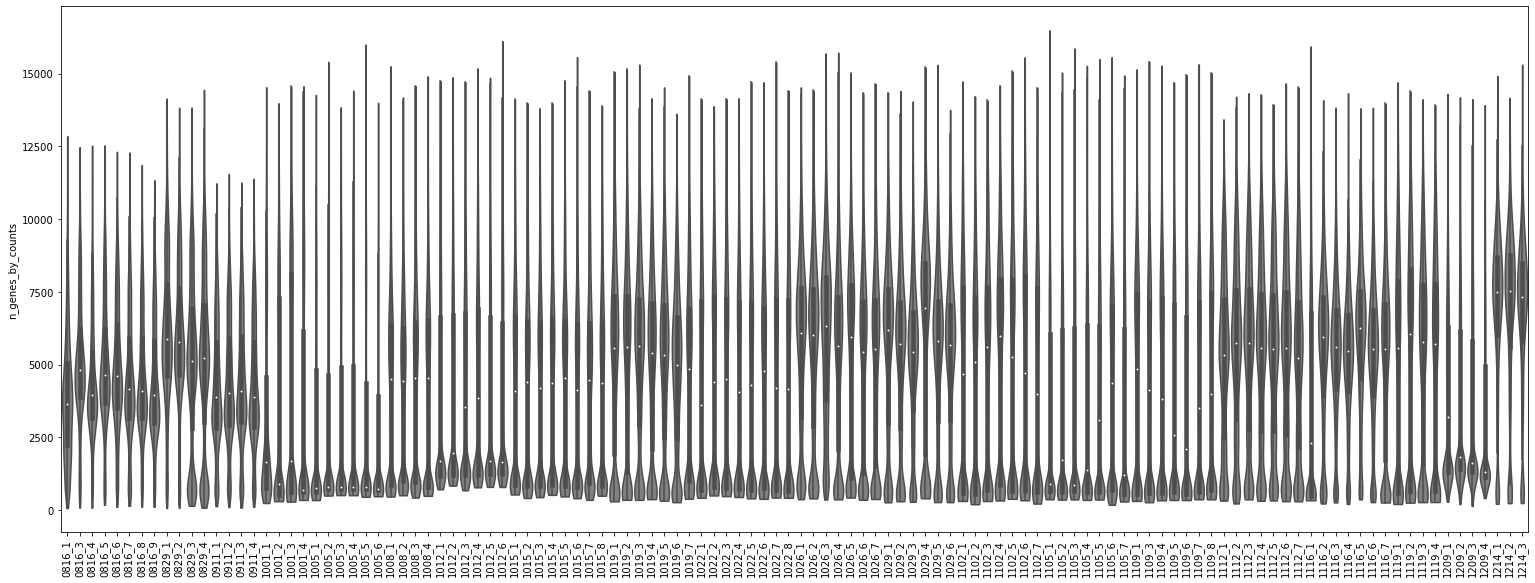

In [7]:
#how does cell quality look in each sample prior to any filtering?
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

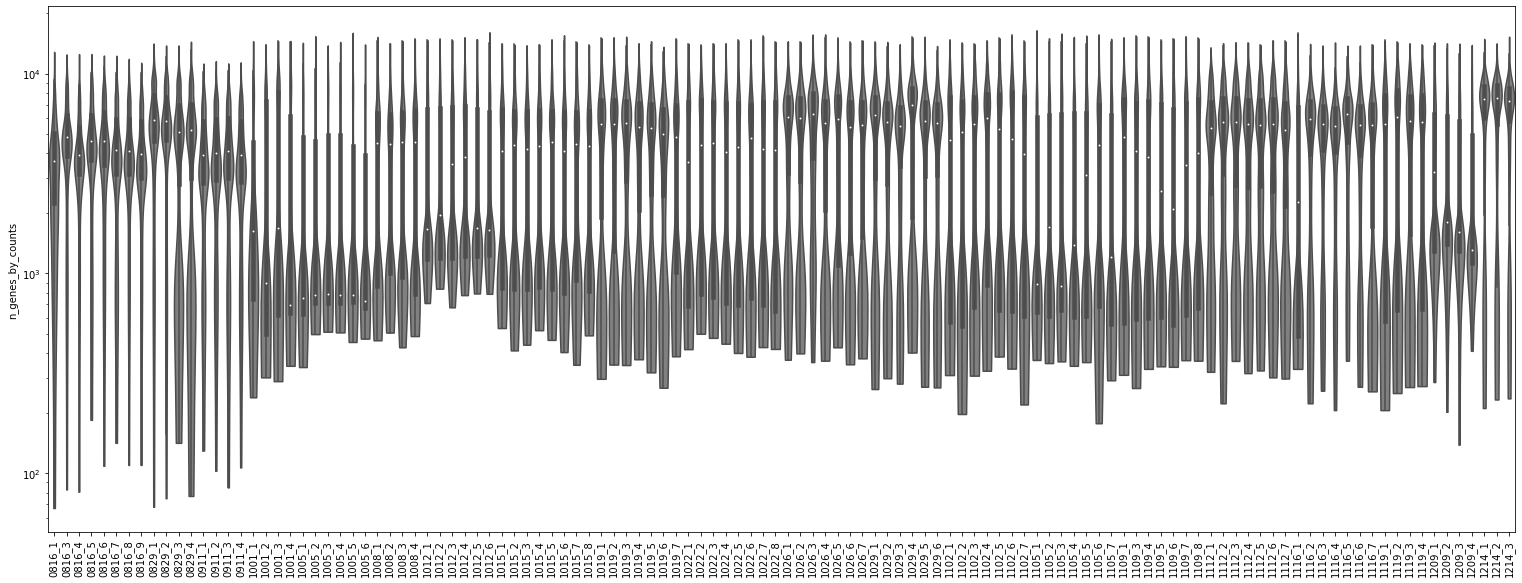

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90, log=True)

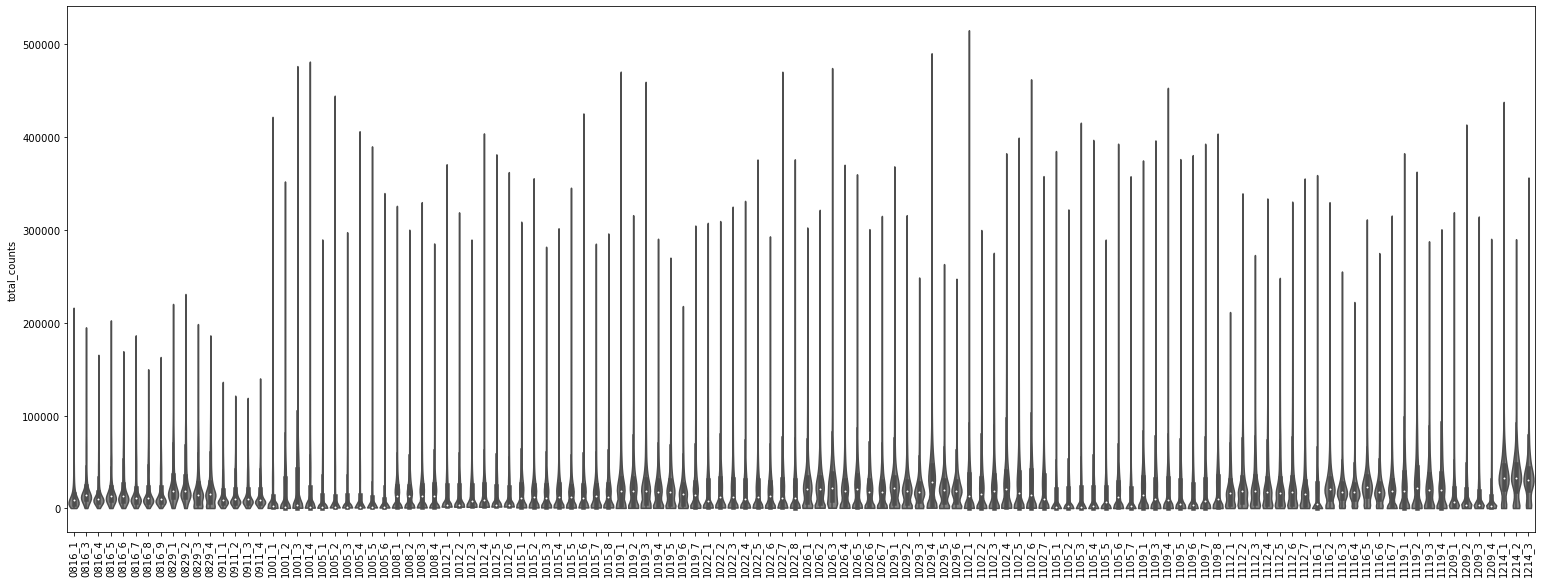

In [9]:
sc.pl.violin(adata, ['total_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

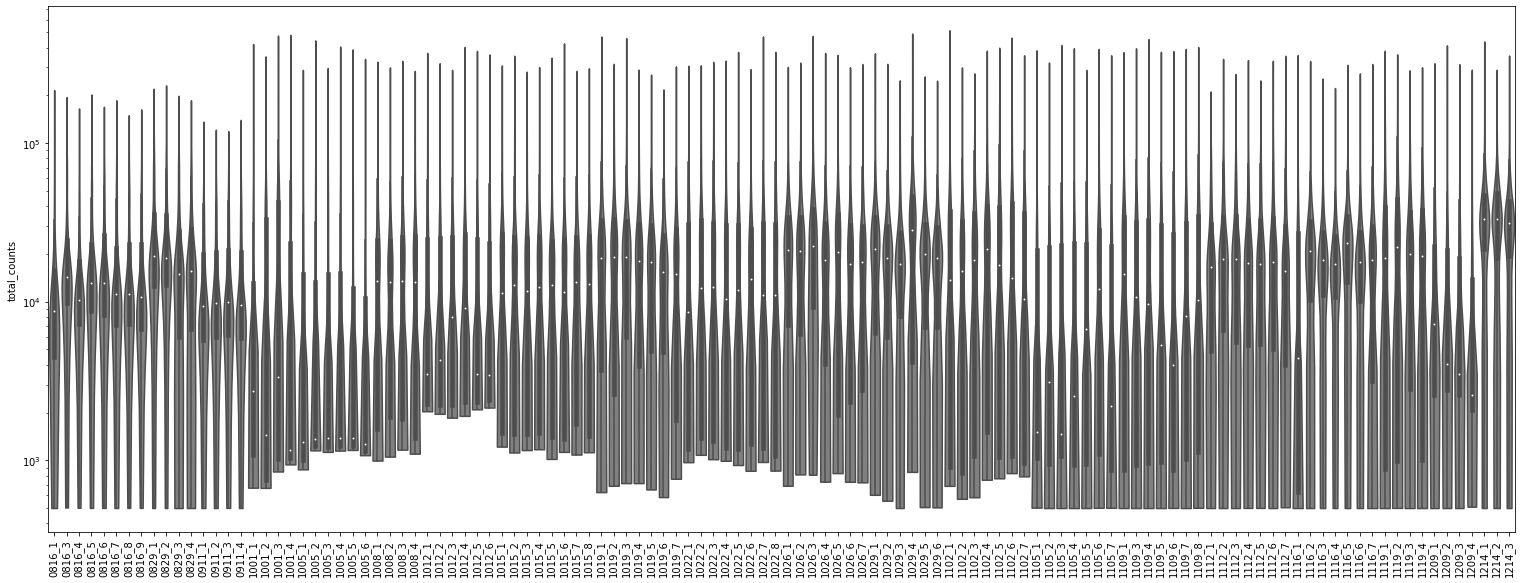

In [10]:
sc.pl.violin(adata, ['total_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90, log=True)

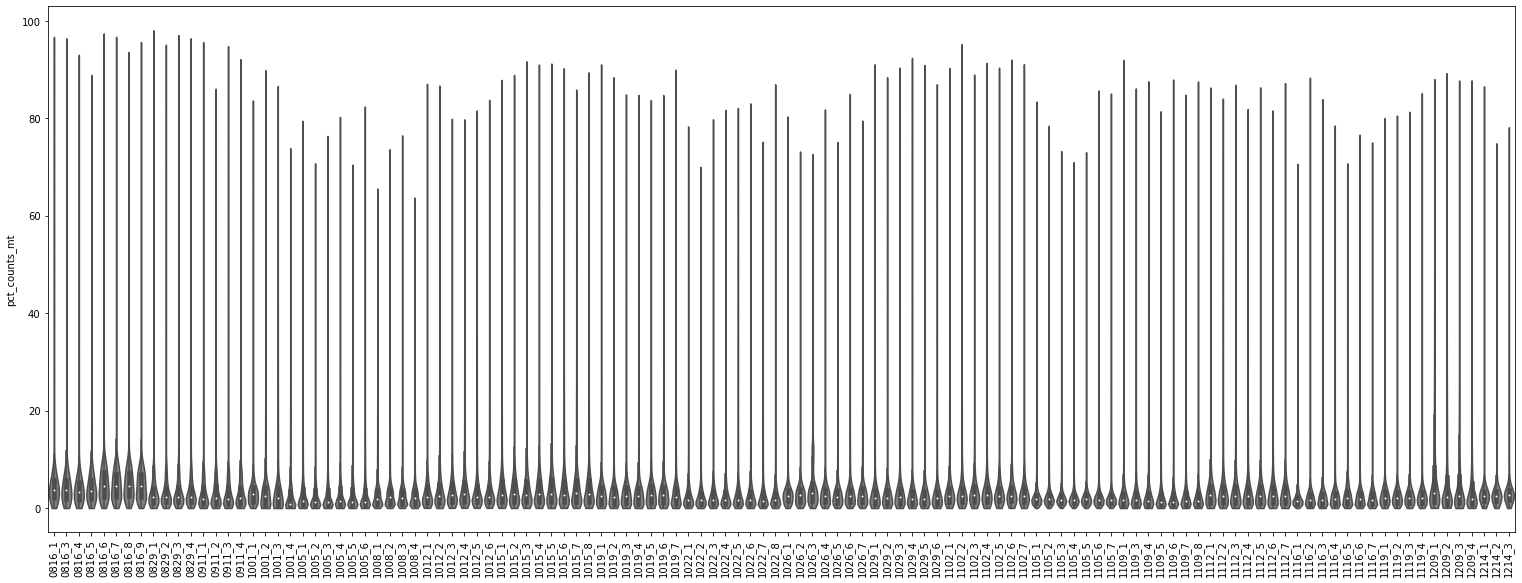

In [11]:
g=sc.pl.violin(adata, ['pct_counts_mt'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

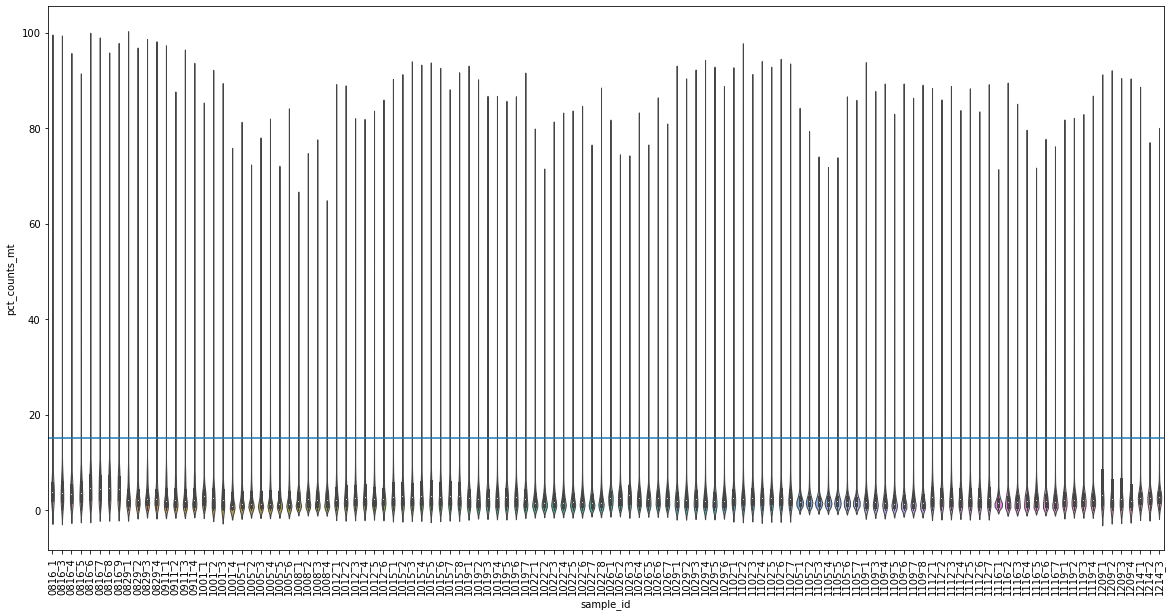

In [12]:
g= sns.violinplot(data=adata.obs, x='sample_id', y=('pct_counts_mt'), linewidth=1)
plt.xticks(rotation=90)
g.axhline(15)

In [13]:
#Will set mt threshold from 0% to 15%

In [14]:
adata.obs['donor_id'].value_counts()

doublet       461787
unassigned    268344
NA18858        63057
NA18499        48257
NA18508        46140
NA18862        35568
NA19193        32291
NA18502        30568
NA18489        28150
NA19206        26233
NA19160        25246
NA19204        25123
NA18856        25087
NA19116        24477
NA19140        24231
NA18486        23429
NA19130        22549
NA18505        22148
NA18855        21752
NA18511        21398
NA19102        21051
NA19144        20787
NA19143        20688
NA18519        20654
NA18912        20640
NA18507        20441
NA19098        20335
NA18517        20277
NA19093        20253
NA19127        20134
NA18913        20011
NA19225        19434
NA18520        19120
NA18522        18977
NA19159        18633
NA19207        17809
NA18907        17674
NA19210        17349
NA19153        16550
NA18516        15679
NA18510        14663
NA18870        13423
NA19152        13249
NA19114        12813
NA19099        12795
NA18501        12326
NA19190        11468
NA19209      

In [15]:
#remove doublets
adata = adata[adata.obs.donor_id != 'doublet', :]
adata = adata[adata.obs.donor_id != 'unassigned', :]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 1095157 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 

In [17]:
#keep only human cells
# nest for loop. top layer: for P1, P2, P3. nested, by unique sample_idin for loop, load human assignment info for each pilot sample
#output a list of chimp barcodes to remove
chimps = pd.DataFrame()
pilot = ["P1", "P2","P3"]
for i in pilot:
    df = adata.obs[adata.obs['Sequencing.batch'] == i]
    ids = df['sample_id'].unique()
    for w in ids:
        coldate = w[0:4]
        bat = 'P'
        lane = w[-1:]
        bt = i[-1:]
        path = "/project2/gilad/kenneth/ebQTL/highpass/batch" + str(bat) +"/" + str(coldate) + "/" + "Batch" + str(bt) +"_Lane" + str(lane) + "_human/human_barcodes.txt"
        humans = pd.read_table(path, header=None)[0]
        #get appropriate suffix for barcode in full data index for this sample_id
        sub = df[df['sample_id'] == w]
        suff = sub.index[0][-4:]
        ind = sub.index
        humans = pd.Series(humans)
        humans = humans.str.replace("-1", suff)
        chi = list(set(ind)-set(humans))
        chimps = chimps.append(chi)
        
        
        
#remove chimp barcods from pilot samples in adata


In [18]:
chimps

,0
0,ATTGGGTAGAATCCCT-103
1,GTCATTTTCGATGCTA-103
2,CCTTGTGTCTCAACCC-103
3,CTACCTGGTGGTTCTA-103
4,ACGATGTAGTTGTAAG-103
...,...
1126,AGGATCTTCGAGCACC-118
1127,GATGAGGAGGTATAGT-118
1128,AGGTGTTGTCCGGACT-118
1129,ACCGTTCAGACAGCGT-118


In [19]:
allhuman = list(set(adata.obs.index)-set(chimps[0]))

In [20]:
len(allhuman)

1079948

In [21]:
allhuman

['AGTCTCCTCGCACGGT-28',
 'ACAGCCGCATCGGATT-13',
 'AGATGAAGTTCCGGTG-38',
 'TCATACTGTCCACGCA-97',
 'CGAAGTTAGTATCTGC-29',
 'CCACTTGGTACGTAGG-82',
 'AGATAGAAGACCACGA-59',
 'AGAGAGCCAGCAGGAT-64',
 'TGTCAGAAGTTGCCTA-55',
 'GCATCTCCACTCCGAG-79',
 'ATCACAGGTTGCGAAG-40',
 'GTATTGGAGTTCCAGT-66',
 'TTCTAGTAGGCTCAAG-47',
 'ATTCACTGTACAGTTC-99',
 'GTAAGTCTCGTCGCTT-11',
 'GGGTTATTCGAAGCCC-39',
 'GCTACAACAATTGCAC-56',
 'TTCTGTAGTTATTCTC-8',
 'ACATCGAGTAACAGTA-77',
 'TACAGGTAGTTAGTGA-100',
 'TGTTGGACACAGTCAT-108',
 'TGATCTTTCTCAAAGC-30',
 'TGCGGCAAGGTTGCCC-27',
 'GATGATCTCATGAGAA-22',
 'TCGCTCATCATTGTGG-88',
 'TTCATTGCACGTACAT-97',
 'ATACCGACAAGCGGAT-77',
 'TCAATCTCAGTTCTAG-104',
 'CAGTTCCTCATTATCC-28',
 'TACATTCCATACTGTG-95',
 'GATTGGTTCCTACAAG-55',
 'GTGACGCGTTAAAGTG-2',
 'AGCCACGGTAACTAAG-34',
 'GTACAGTTCACGAACT-82',
 'GTTATGGCACTCGATA-56',
 'TCGGGACGTAGACTGG-108',
 'ACGCACGAGCGTGAGT-68',
 'CAAGACTCAGGATCTT-83',
 'GGCAGTCCAGGCTTGC-11',
 'GATTCGAAGAGTAACT-35',
 'AGGCCACAGCGACTGA-93',
 'GATCAGTGTTAT

In [22]:
#keep only the human barcodes
adata = adata[allhuman]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 1079948 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 

In [24]:
adata.obs['Sequencing.batch'].value_counts()

9     134836
5     111462
2     107321
7     102332
4     101690
8      96209
6      95896
3      95190
10     92860
1      64782
P1     41309
P3     20033
P2     16028
Name: Sequencing.batch, dtype: int64

In [25]:
#remove non YRI
adata.obs['donor_id'].value_counts()

NA18858    60227
NA18499    48257
NA18508    46140
NA18862    35568
NA19193    32291
NA18502    30568
NA18489    28150
NA19206    26233
NA19204    25123
NA18856    25087
NA19116    24477
NA19140    24231
NA18486    23429
NA19130    22549
NA18505    22148
NA18855    21752
NA19160    21349
NA19102    21051
NA19144    20787
NA19143    20688
NA18519    20654
NA18912    20640
NA18507    20441
NA19098    20335
NA18517    20277
NA19093    20253
NA19127    20134
NA18913    20011
NA19225    19434
NA18520    19120
NA18522    18977
NA19159    18633
NA19207    17809
NA18511    17793
NA18907    17674
NA19210    17349
NA19153    16550
NA18516    15679
NA18510    14663
NA18870    13423
NA19152    13249
NA19114    12813
NA19099    12795
NA18501    12326
NA19190    11468
NA19209    10775
NA19101    10523
NA19257     8714
SCM-10      6518
H28834      6487
SCM-9       6213
NA19203     5787
NA19128     3903
NA19119     3578
NA19108     2812
NA18498     2033
Name: donor_id, dtype: int64

In [26]:
adata = adata[adata.obs.donor_id != 'SCM-10', :]
adata = adata[adata.obs.donor_id != 'SCM-9', :]
adata = adata[adata.obs.donor_id != 'H28834', :]

In [27]:
adata.obs['donor_id'].value_counts()

NA18858    60227
NA18499    48257
NA18508    46140
NA18862    35568
NA19193    32291
NA18502    30568
NA18489    28150
NA19206    26233
NA19204    25123
NA18856    25087
NA19116    24477
NA19140    24231
NA18486    23429
NA19130    22549
NA18505    22148
NA18855    21752
NA19160    21349
NA19102    21051
NA19144    20787
NA19143    20688
NA18519    20654
NA18912    20640
NA18507    20441
NA19098    20335
NA18517    20277
NA19093    20253
NA19127    20134
NA18913    20011
NA19225    19434
NA18520    19120
NA18522    18977
NA19159    18633
NA19207    17809
NA18511    17793
NA18907    17674
NA19210    17349
NA19153    16550
NA18516    15679
NA18510    14663
NA18870    13423
NA19152    13249
NA19114    12813
NA19099    12795
NA18501    12326
NA19190    11468
NA19209    10775
NA19101    10523
NA19257     8714
NA19203     5787
NA19128     3903
NA19119     3578
NA19108     2812
NA18498     2033
Name: donor_id, dtype: int64

In [28]:
adata

View of AnnData object with n_obs × n_vars = 1060730 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 

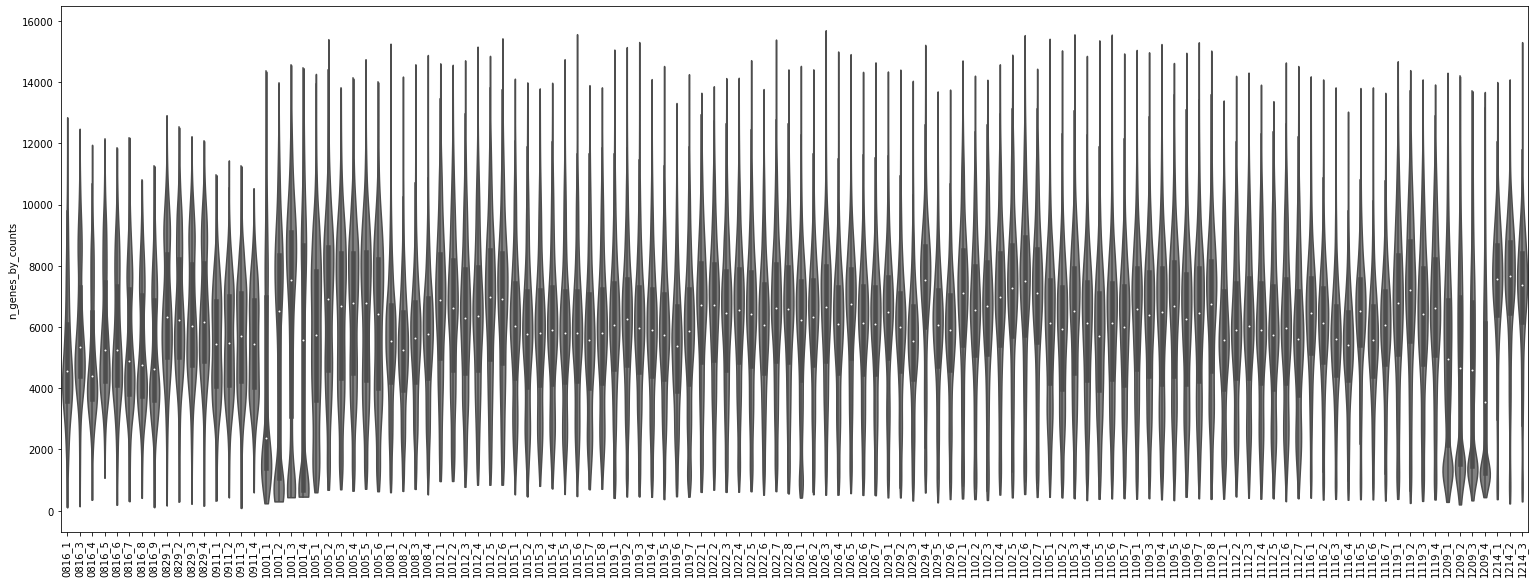

In [29]:
#replot QC
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

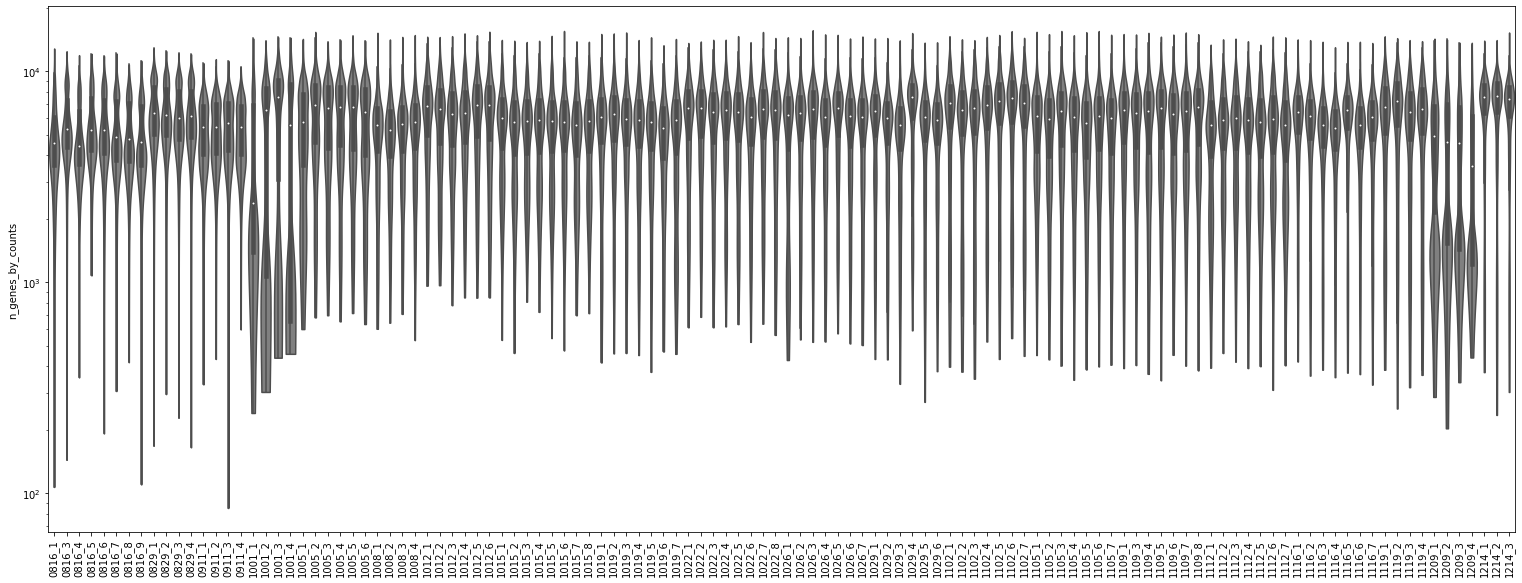

In [30]:
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90, log=True)

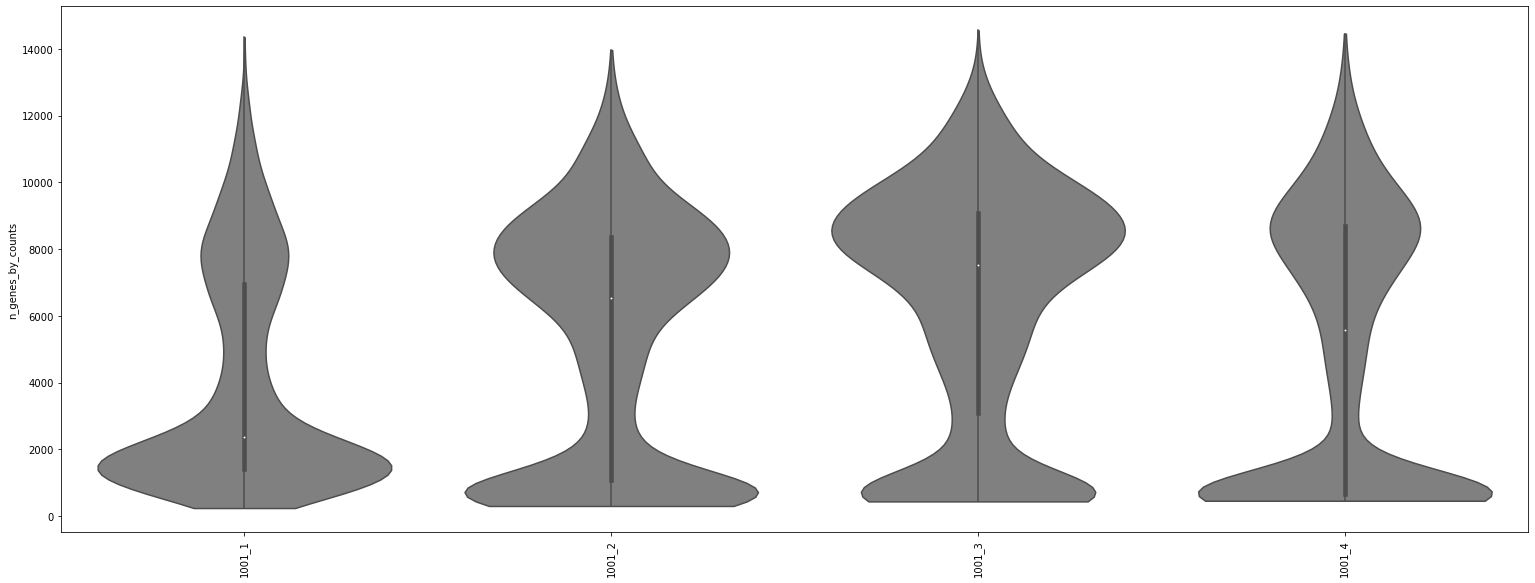

In [31]:
#get a clearer look at the violin plots for lanes colelcted on 1001 and 1209
sub = adata[adata.obs['col.group']==100120]
sc.pl.violin(sub, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

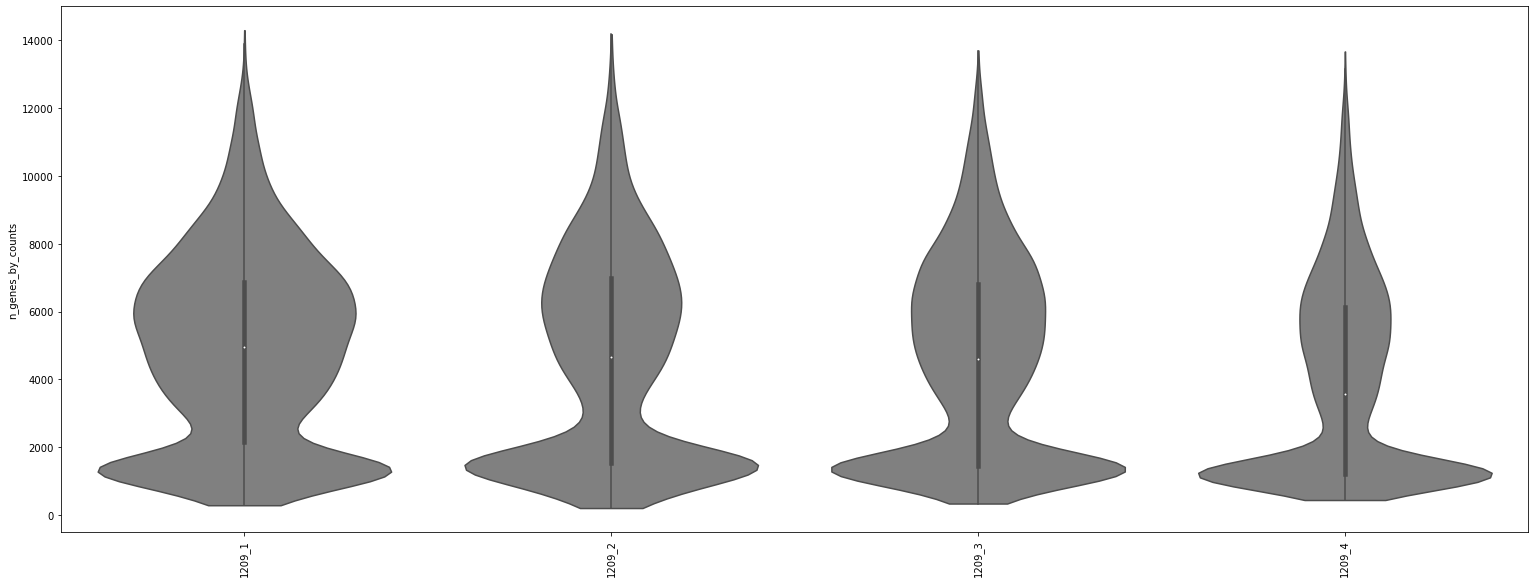

In [32]:
sub = adata[adata.obs['col.group']==120920]
sc.pl.violin(sub, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

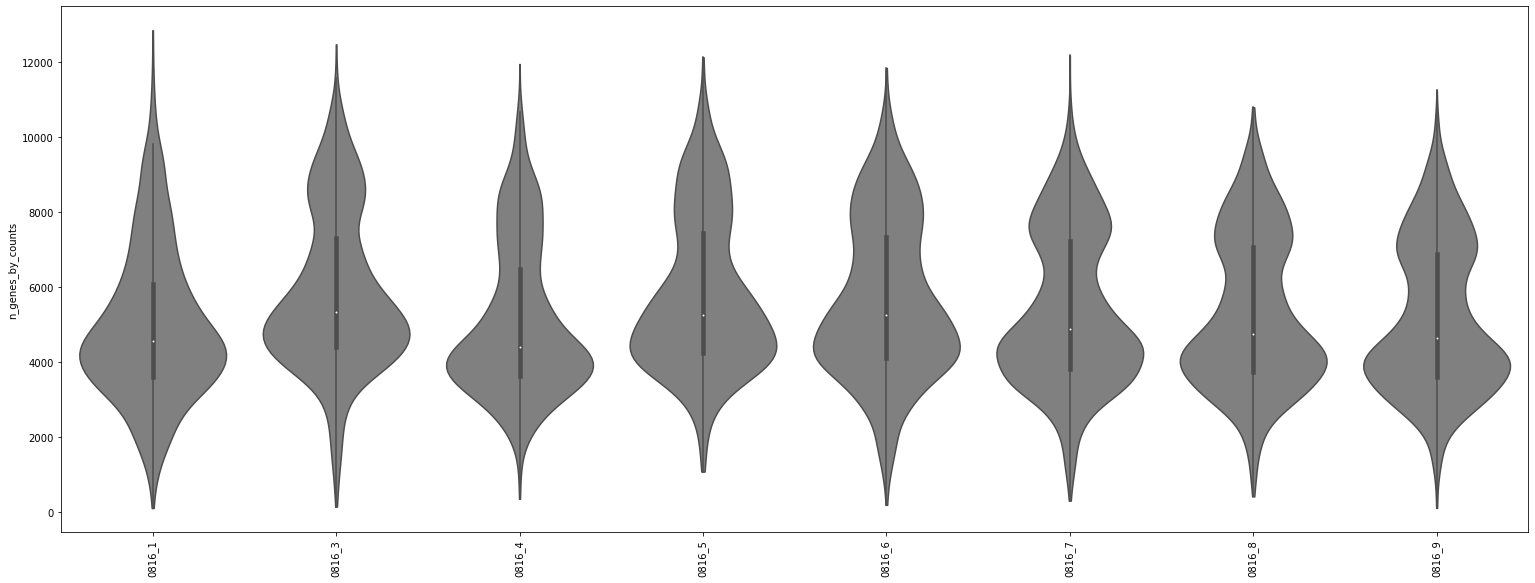

In [33]:
sub = adata[adata.obs['Sequencing.batch'] == 'P1']
sc.pl.violin(sub, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

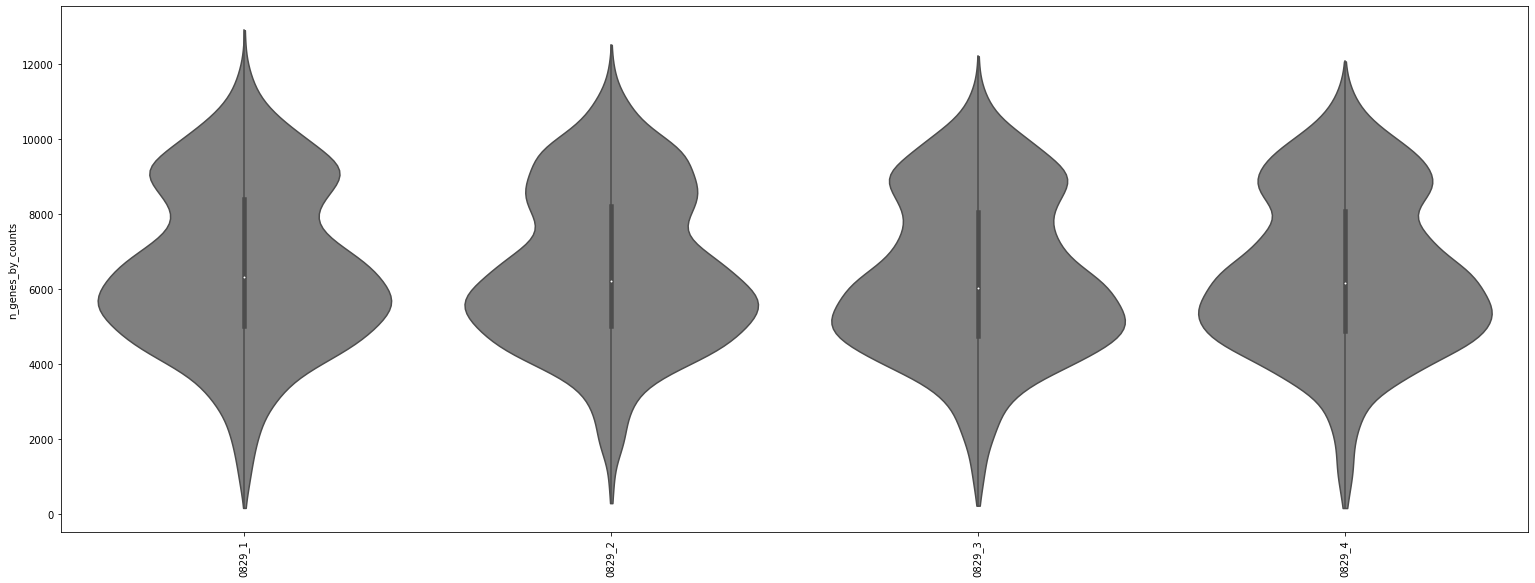

In [34]:
sub = adata[adata.obs['Sequencing.batch'] == 'P2']
sc.pl.violin(sub, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

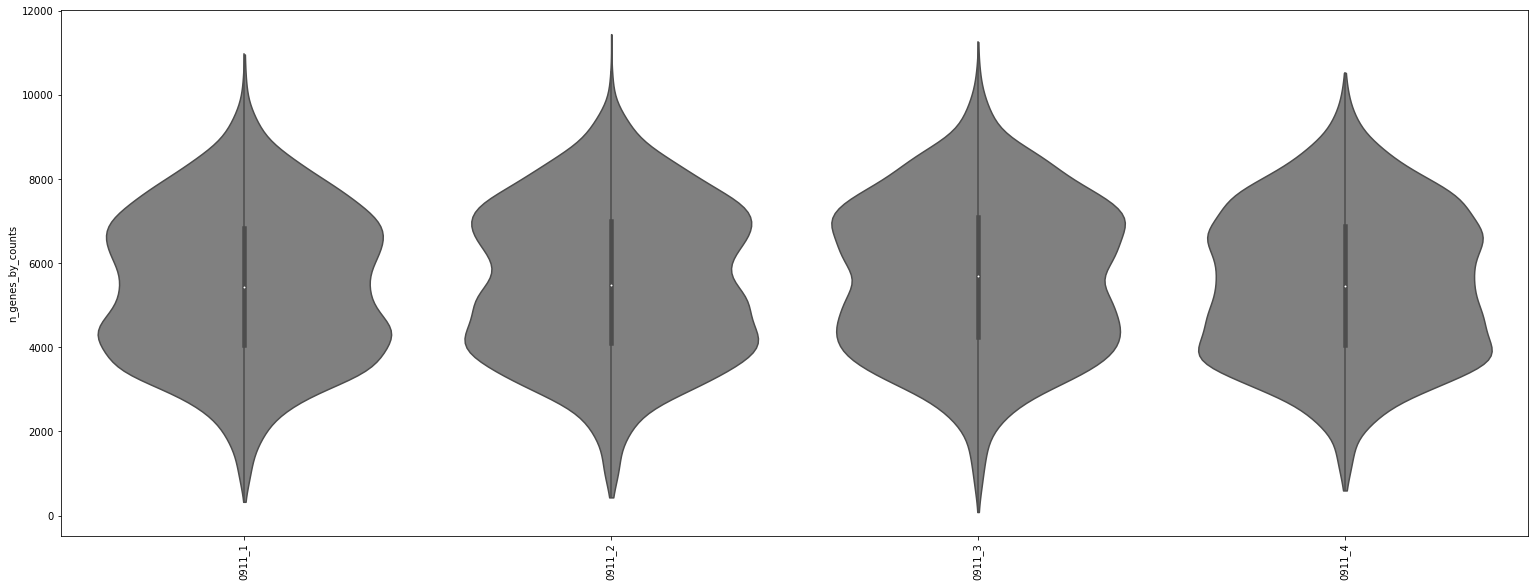

In [35]:
sub = adata[adata.obs['Sequencing.batch'] == 'P3']
sc.pl.violin(sub, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90)

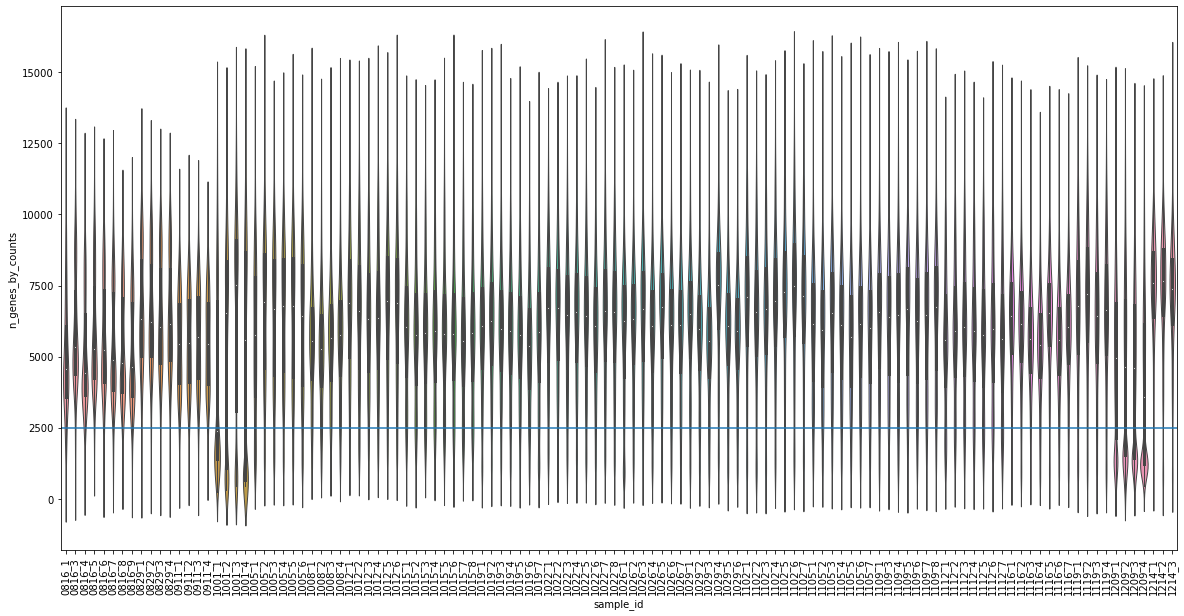

In [36]:
g= sns.violinplot(data=adata.obs, x='sample_id', y=('n_genes_by_counts'), linewidth=1)
plt.xticks(rotation=90)
g.axhline(2500)

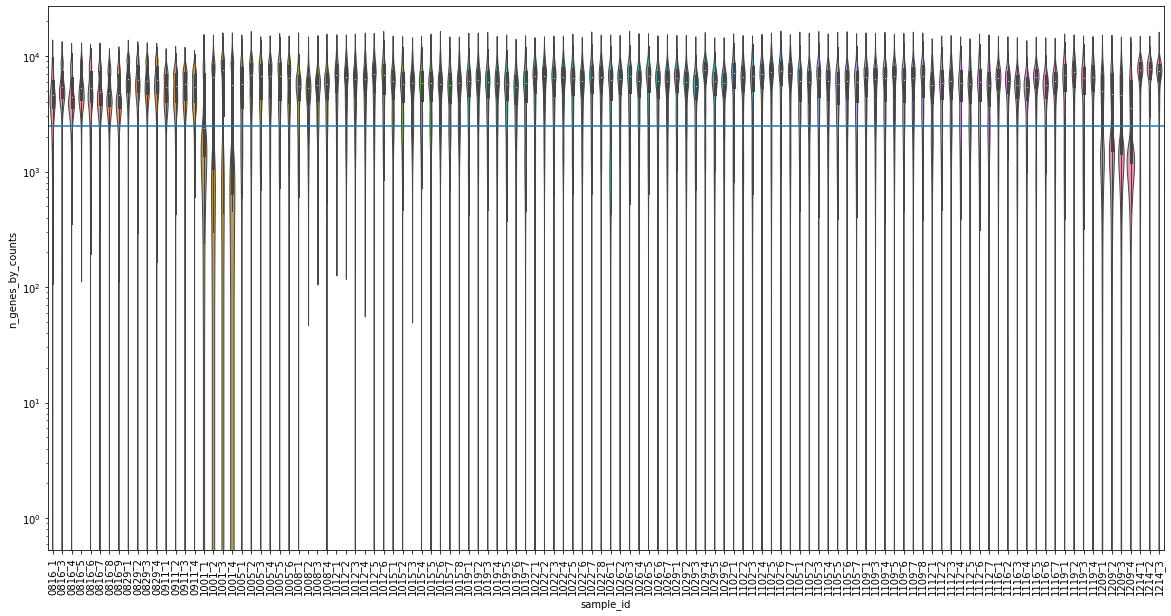

In [37]:
g= sns.violinplot(data=adata.obs, x='sample_id', y=('n_genes_by_counts'), linewidth=1)
plt.xticks(rotation=90)
g.set_yscale("log")
g.axhline(2500)

In [38]:
#set n_genes_by_counts minimum to 2500

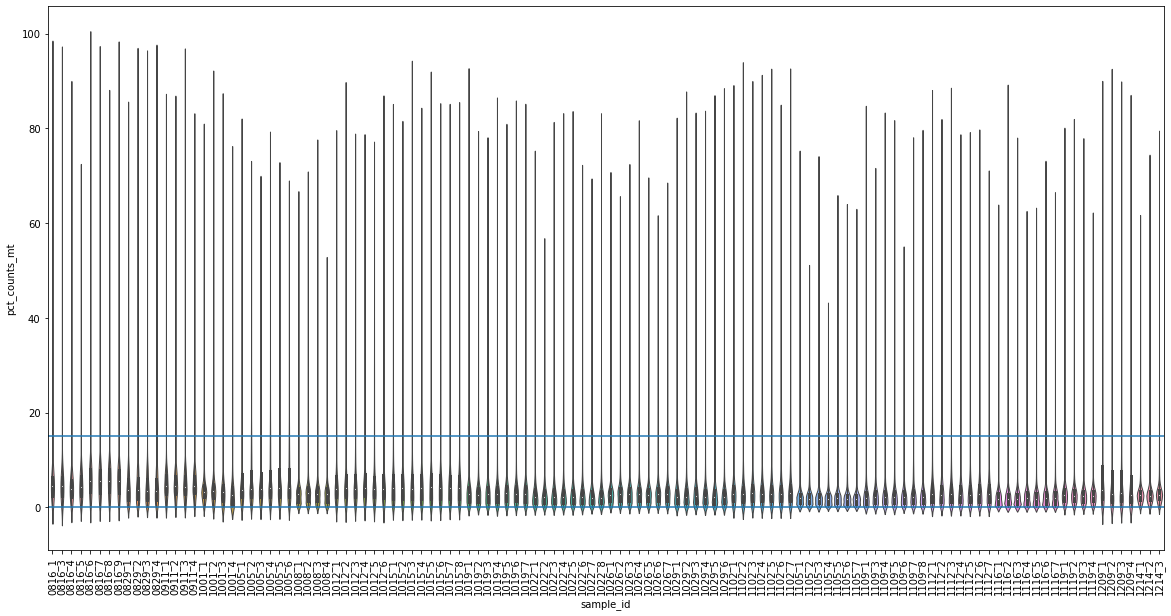

In [39]:
#already decided on mt thresholds, but plotting again after doublet removal:
g= sns.violinplot(data=adata.obs, x='sample_id', y=('pct_counts_mt'), linewidth=1)
plt.xticks(rotation=90)
g.axhline(0)
g.axhline(15)

In [40]:
adata.obs.pct_counts_mt.describe()

count    1.060730e+06
mean     4.136059e+00
std      5.974126e+00
min      0.000000e+00
25%      1.186651e+00
50%      2.684851e+00
75%      4.458653e+00
max      9.738400e+01
Name: pct_counts_mt, dtype: float64

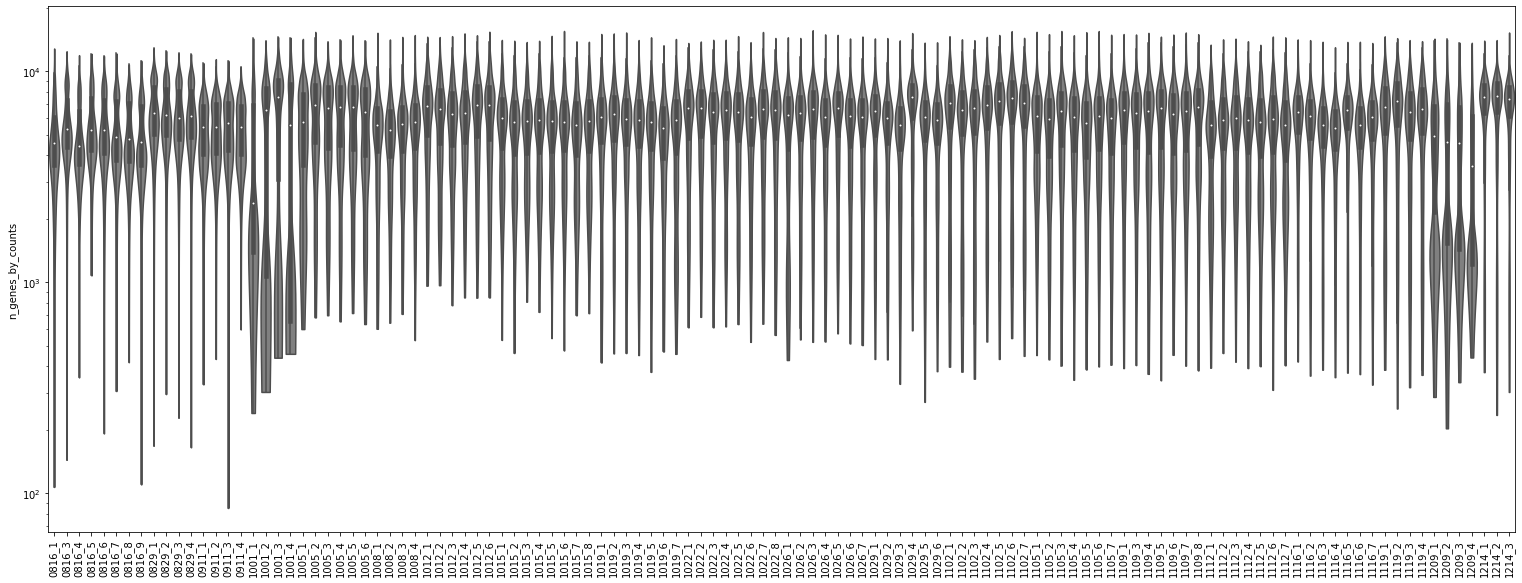

In [41]:
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='sample_id', stripplot=False, inner='box', rotation=90, log=True)

In [42]:
#filter n_genes_by_counts
adata = adata[adata.obs.n_genes_by_counts > 2500, :]

In [43]:
#filter by mt%
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 917381 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', '

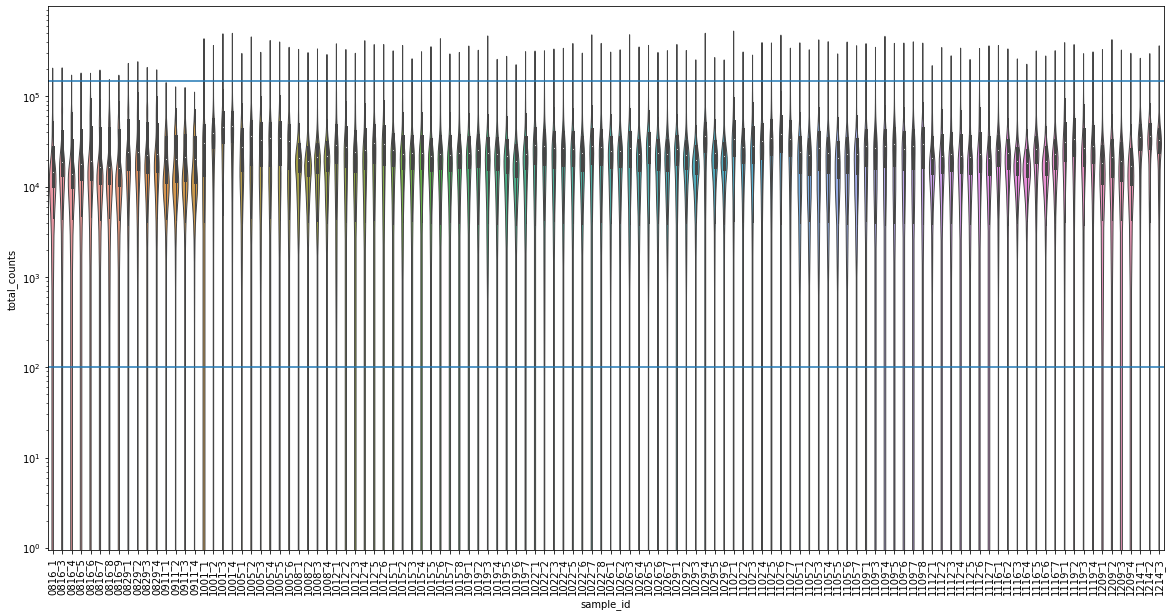

In [45]:
#plot total counts, will need to set a max threshold because some have really high
g= sns.violinplot(data=adata.obs, x='sample_id', y=('total_counts'), linewidth=1)
plt.xticks(rotation=90)
g.set_yscale("log")
g.axhline(100)
g.axhline(150000)

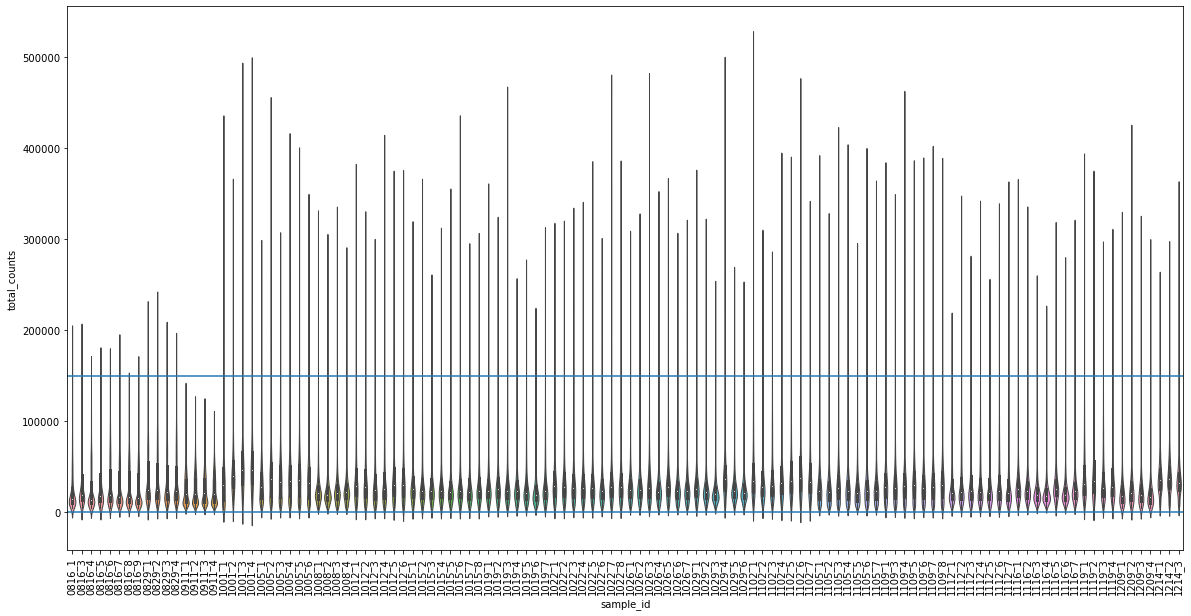

In [46]:
g= sns.violinplot(data=adata.obs, x='sample_id', y=('total_counts'), linewidth=1)
plt.xticks(rotation=90)
g.axhline(100)
g.axhline(150000)


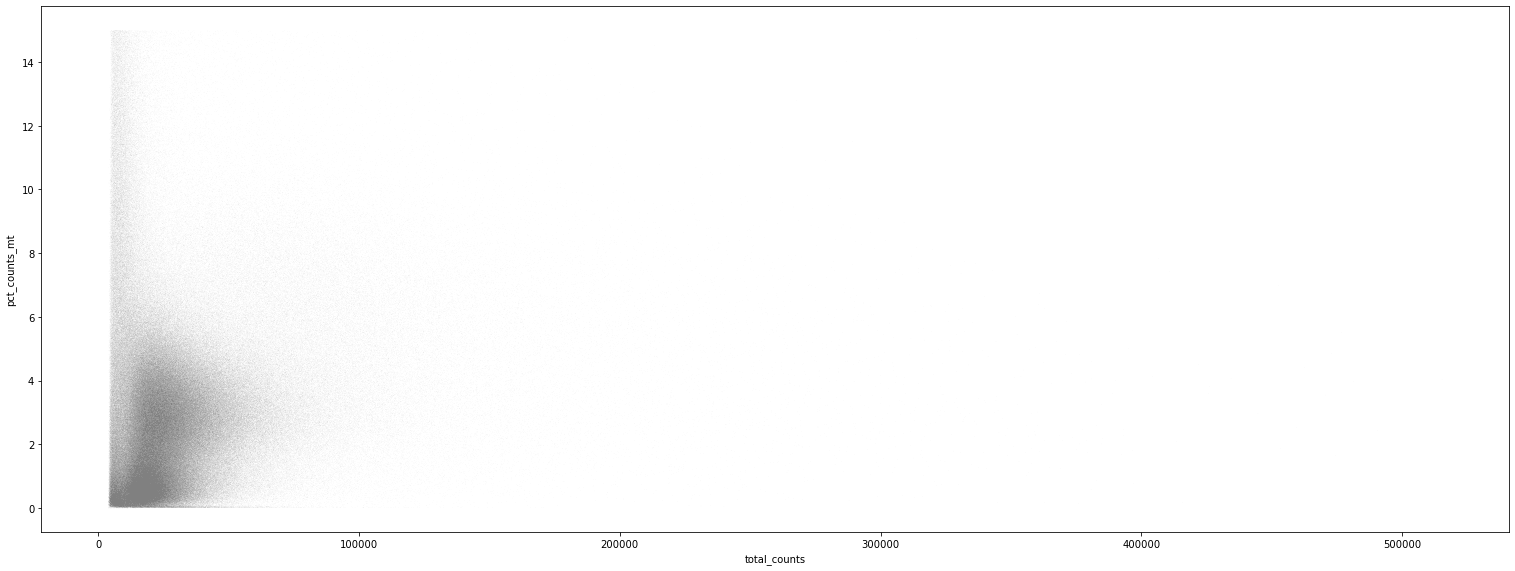

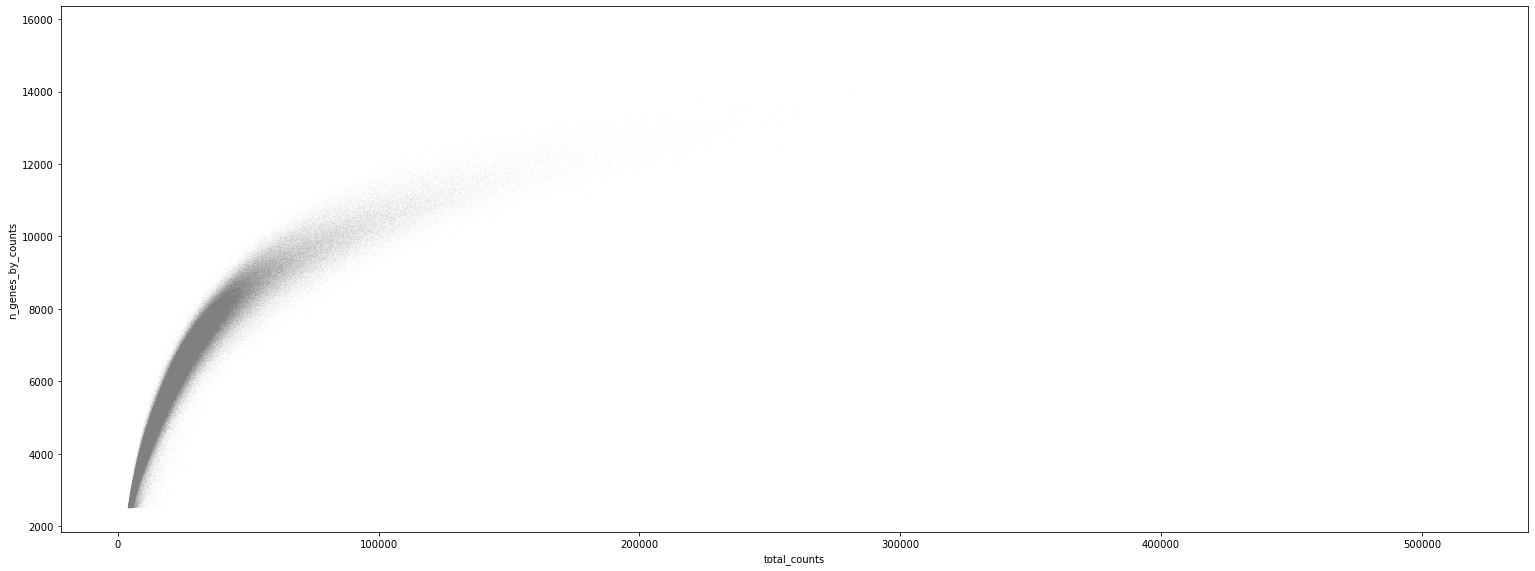

In [47]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [48]:
adata.obs.total_counts.describe()

count    917381.000000
mean      32120.869141
std       27794.267578
min        3749.000000
25%       15620.000000
50%       24525.000000
75%       38527.000000
max      515265.000000
Name: total_counts, dtype: float64

In [49]:
sum(adata.obs.total_counts > 150000)

7845

In [50]:
adata

View of AnnData object with n_obs × n_vars = 917381 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', '

In [51]:
adata = adata[adata.obs.total_counts < 150000, :]

In [52]:
adata

View of AnnData object with n_obs × n_vars = 909536 × 36601
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', '

In [53]:
adata.var.head()

,gene_ids,feature_types,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,1770,0.000979,99.903029,1787.0
FAM138A,ENSG00000237613,Gene Expression,False,2,0.000001,99.999890,2.0
OR4F5,ENSG00000186092,Gene Expression,False,94,0.000051,99.994850,94.0
AL627309.1,ENSG00000238009,Gene Expression,False,35673,0.021781,98.045623,39757.0
AL627309.3,ENSG00000239945,Gene Expression,False,149,0.000082,99.991837,149.0


/project2/gilad/katie/miniconda3/envs/scvi2/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


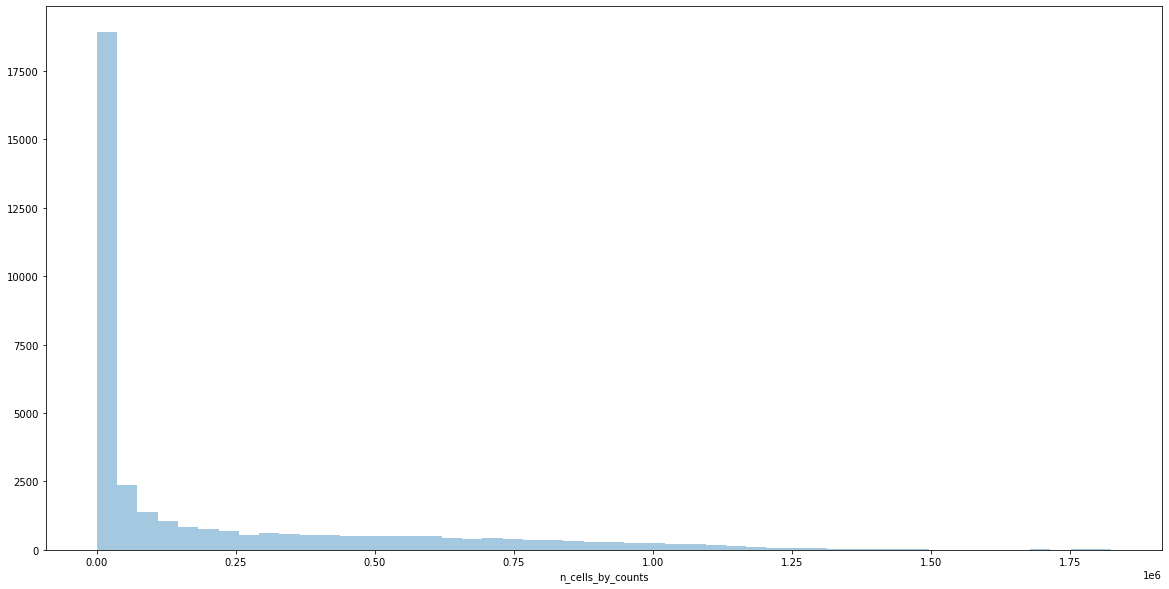

In [54]:
g= sns.distplot(adata.var['n_cells_by_counts'], kde=False)

<AxesSubplot:xlabel='n_cells_by_counts'>

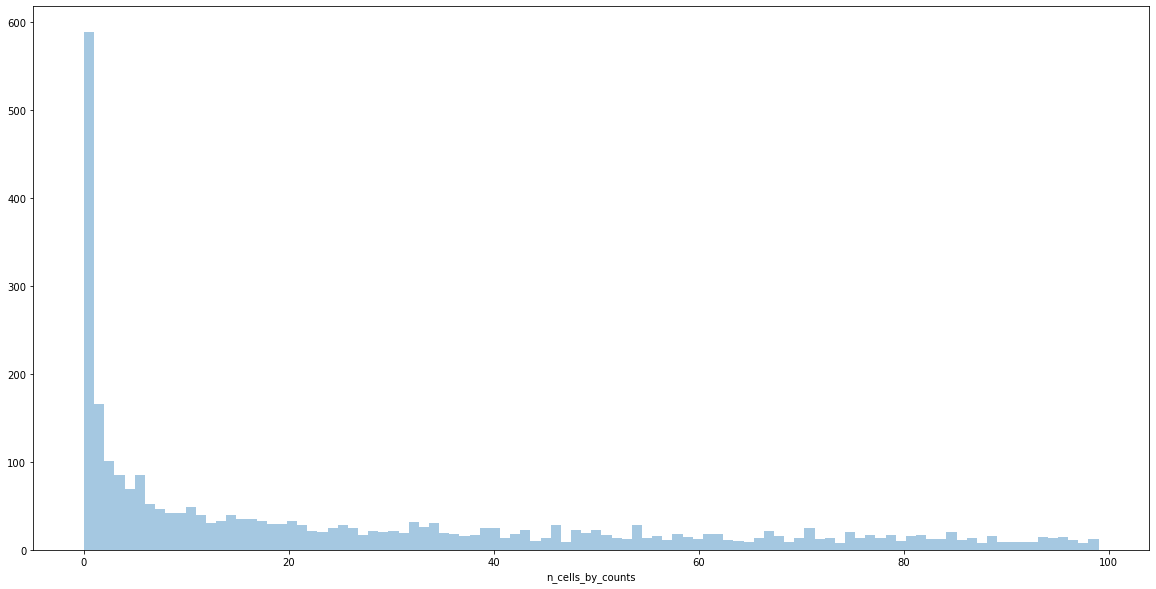

In [55]:
sub = adata[:, adata.var.n_cells_by_counts < 100]
g= sns.distplot(sub.var['n_cells_by_counts'], bins=100, kde=False)
g

<AxesSubplot:xlabel='n_cells_by_counts'>

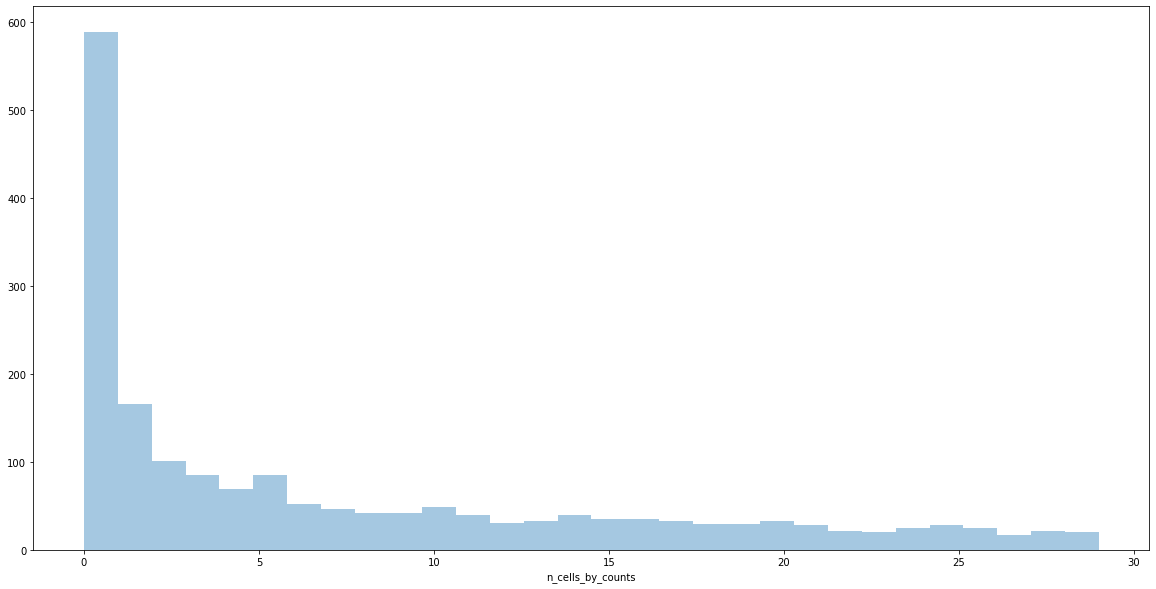

In [56]:
sub = adata[:, adata.var.n_cells_by_counts < 30]
g= sns.distplot(sub.var['n_cells_by_counts'], bins=30, kde=False)
g

In [57]:
sum(adata.var.n_cells_by_counts < 10)

1277

In [58]:
#filter genes expressed in fewer than 10 cells
adata = adata[:, adata.var.n_cells_by_counts >= 10]

In [59]:
adata

View of AnnData object with n_obs × n_vars = 909536 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', '

In [60]:
#output csv with filtered barcodes to KEEP
keep = adata.obs.index
keep=pd.Series(keep)
keep

0          ACAGCCGCATCGGATT-13
1          CGAAGTTAGTATCTGC-29
2          CCACTTGGTACGTAGG-82
3          AGATAGAAGACCACGA-59
4          AGAGAGCCAGCAGGAT-64
                  ...         
909531     CACGAATAGTATAGGT-99
909532      TAACACGAGTTGGACG-3
909533     AGACACTCACATATCG-34
909534     GCCAGGTGTAATACCC-18
909535    TGTGTGACACAAGCTT-102
Name: cell, Length: 909536, dtype: object

In [61]:
keep.to_csv(path_or_buf= '/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_FilteredBarcodesToKeep.csv')

In [62]:
genes = adata.var.index
genes = pd.Series(genes)
genes

0        MIR1302-2HG
1              OR4F5
2         AL627309.1
3         AL627309.3
4         AL627309.2
            ...     
35319     AC136616.3
35320     AC023491.2
35321     AC007325.1
35322     AC007325.4
35323     AC007325.2
Length: 35324, dtype: object

In [63]:
genes.to_csv(path_or_buf= '/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_FilteredGenesToKeep.csv')

In [64]:
print(np.__version__)

1.20.3


In [65]:
print(sc.__version__)

1.8.1


In [66]:
print(pd.__version__)

1.3.0


In [67]:
print(matplotlib.__version__)

3.4.2


In [68]:
print(sns.__version__)

0.11.1
